In [35]:
%%time
%matplotlib inline
import numpy as np
import pandas as pd
import pywt
import seaborn as sns
import scaleogram as scg 
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
from mat4py import loadmat
from scipy.fftpack import fft
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import sys
from tensorflow import keras

CPU times: user 5.67 s, sys: 2.1 s, total: 7.77 s
Wall time: 17.4 s


In [23]:
data = loadmat("./ECGData/ECGData.mat")

In [24]:
ecg_total = len(data['ECGData']['Data'])
ecg_data = []
ecg_labels = []
for i in range(0, ecg_total):
    ecg_data.append(data['ECGData']['Data'][i])
    ecg_labels.append(data['ECGData']['Labels'][i])

ecg_labels=np.array(ecg_labels)
ecg_labels = ecg_labels.reshape(-1)

Text(0.5, 1.0, 'NSR Signal')

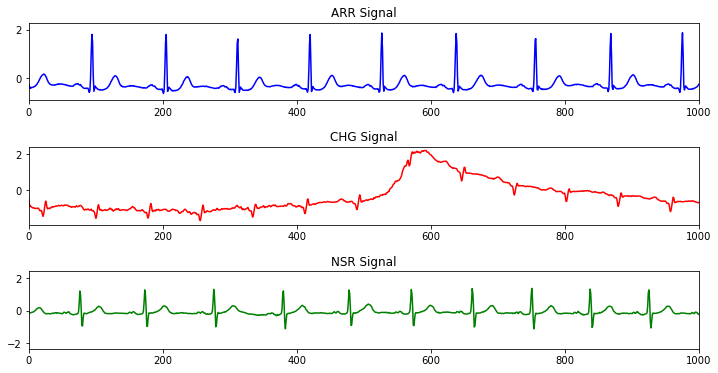

In [25]:
fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(3, 1, hspace=0.6)

arr_signal = fig.add_subplot(grid[0, 0])
chg_signal = fig.add_subplot(grid[1, 0])
nsr_signal = fig.add_subplot(grid[2, 0])

arr_signal.plot(range(0, len(data['ECGData']['Data'][33]), 1), ecg_data[33], color = 'blue')
arr_signal.set_xlim(0, 1000)
arr_signal.set_title('ARR Signal')

chg_signal.plot(range(0, len(data['ECGData']['Data'][100]), 1), ecg_data[100], color = 'red')
chg_signal.set_xlim(0, 1000)
chg_signal.set_title('CHG Signal')

nsr_signal.plot(range(0, len(data['ECGData']['Data'][150]), 1), ecg_data[150], color = 'green')
nsr_signal.set_xlim(0, 1000)
nsr_signal.set_title('NSR Signal')

In [26]:
N = 10000
x_values = np.linspace(0, 100, N)
amplitudes = [4, 1.5, 9]
frequencies = [2, 5, 3]
y_values_0 = amplitudes[0]*np.cos(2*np.pi*frequencies[0]*x_values) 
y_values_1 = amplitudes[1]*np.sin(2*np.pi*frequencies[1]*x_values) 
y_values_2 = amplitudes[2]*np.cos(2*np.pi*frequencies[2]*x_values + 0.4) 
    

full_signal_values = (y_values_0 + y_values_1 - y_values_2)
full_signal_fft_values = fft(full_signal_values)
full_signal_fft_values = (2/N) * np.abs(full_signal_fft_values)

In [27]:
N = 10000
x_values_wvt = np.linspace(0, 100, N)
amplitudes = [4, 1.5, 9]
frequencies = [2, 5, 3]
y_values_0 = amplitudes[0]*np.cos(2*np.pi*frequencies[0]*x_values) 
y_values_1 = amplitudes[1]*np.sin(2*np.pi*frequencies[1]*x_values) 
y_values_2 = amplitudes[2]*np.cos(2*np.pi*frequencies[2]*x_values + 0.4) 
full_signal_values = (y_values_0 + y_values_1 - y_values_2)

wavelet='cmor0.7-1.5'

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


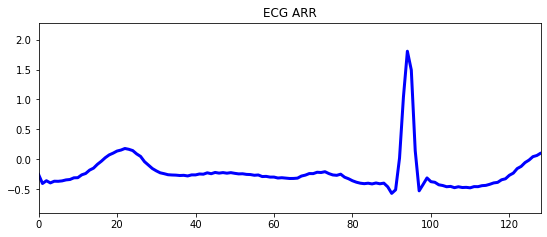

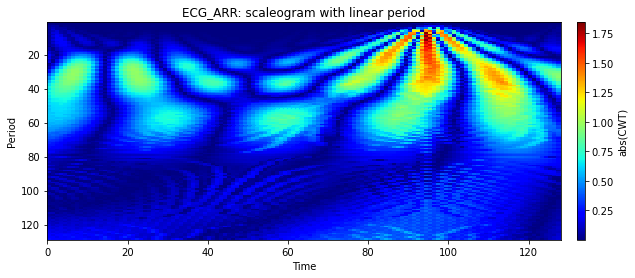

In [28]:
# choose default wavelet function 
scg.set_default_wavelet('morl')

nn = 33
signal_length = 128
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(ecg_data[nn]),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, ecg_data[nn], linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title("ECG ARR")

# the scaleogram
scg.cws(ecg_data[nn][:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title='ECG_ARR: scaleogram with linear period'); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

In [29]:
arr_list = ecg_data[0:95]
chf_list = ecg_data[96:125]
nsr_list = ecg_data[126:162]

arr_split_256 = [np.array_split(arr_list[ii], 256) for ii in range(95)]
arr_flatten = [item for sublist in arr_split_256 for item in sublist]

chf_split_256 = [np.array_split(chf_list[ii], 256) for ii in range(29)]
chf_flatten = [item for sublist in chf_split_256 for item in sublist]

nsr_split_256 = [np.array_split(nsr_list[ii], 256) for ii in range(36)]
nsr_flatten = [item for sublist in nsr_split_256 for item in sublist]

In [31]:
reduce_size = 500
full_1500 = (arr_flatten[0:reduce_size] + chf_flatten[0:reduce_size] + nsr_flatten[0:reduce_size])

In [33]:
fs = len(full_1500[0])
sgn_length = 2000   #65536   Pay atention with ram memory! 
size_dataset = len(full_1500)
scales = range(1, fs)
waveletname = 'morl'
 
X_full = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))
                 
for i in range(0, size_dataset):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_1500[i]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        X_full[i, :, :, j] = coeff[:,:fs-1]

0 done!
500 done!
1000 done!


In [34]:
list_ecg_labels_arr = ['ARR']*reduce_size 
list_ecg_labels_chf = ['CHF']*reduce_size 
list_ecg_labels_nsr = ['NSR']*reduce_size 
list_ecg_labels = (list_ecg_labels_arr + list_ecg_labels_chf + list_ecg_labels_nsr)

le = preprocessing.LabelEncoder()
ecg_labels_encoded = le.fit_transform(list_ecg_labels)
X_train, X_test, y_train, y_test = train_test_split(X_full, ecg_labels_encoded, test_size=0.25, random_state=42)

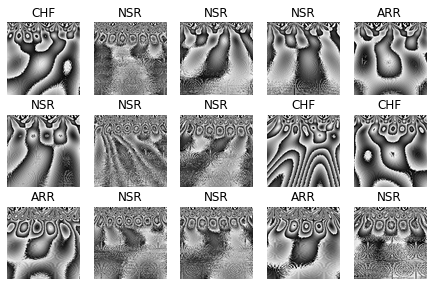

In [36]:
n_rows = 3
n_cols = 5
class_names = ['ARR', 'CHF', 'NSR']
plt.figure(figsize=(n_cols*1.5, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_train[index]*255).astype(np.uint8), cmap="binary", interpolation="spline36")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

In [37]:
num_filter, num_classes = 3, 3
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fs-1, fs-1, num_filter]),
    keras.layers.Dense(300, activation="relu"),                 
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

2021-10-31 13:54:28.440492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 195075)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               58522800  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 58,553,203
Trainable params: 58,553,203
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

2021-10-31 13:54:54.587280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
36/36 [==============================] - 9s 236ms/step - loss: 1.1263 - accuracy: 0.7076 - val_loss: 0.4064 - val_accuracy: 0.8240
Epoch 2/10
36/36 [==============================] - 8s 212ms/step - loss: 0.2186 - accuracy: 0.9227 - val_loss: 0.3620 - val_accuracy: 0.8933
Epoch 3/10
36/36 [==============================] - 6s 178ms/step - loss: 0.1323 - accuracy: 0.9600 - val_loss: 0.2160 - val_accuracy: 0.9227
Epoch 4/10
36/36 [==============================] - 7s 186ms/step - loss: 0.0796 - accuracy: 0.9760 - val_loss: 1.4560 - val_accuracy: 0.7227
Epoch 5/10
36/36 [==============================] - 7s 182ms/step - loss: 0.2387 - accuracy: 0.9324 - val_loss: 0.3733 - val_accuracy: 0.8960
Epoch 6/10
36/36 [==============================] - 7s 182ms/step - loss: 0.0739 - accuracy: 0.9760 - val_loss: 0.1779 - val_accuracy: 0.9600
Epoch 7/10
36/36 [==============================] - 7s 192ms/step - loss: 0.0568 - accuracy: 0.9778 - val_loss: 0.2391 - val_accuracy: 0.9547
Epoch 

In [40]:
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', size = 16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('Figure_epochs.png')   
    plt.close()

In [41]:
learning_curves(history)

In [43]:
prediction = model.predict(X_test)
pred_classes = prediction.argmax(axis=1)

In [42]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_classes)
cm_norm =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

NameError: name 'pred_classes' is not defined